# Project Notebook

## Social Data Science - exam notebook


#### Authors: 
#### Anton Maach-Møller
#### Christian Nøjgaard Fogdal

## 1. Installations

In [138]:
# pip install geopy
# pip install textblob
# pip install vaderSentiment
# pip install emoji
# nltk.download('stopwords')
# nltk.download('vader_lexicon')
# pip install statsmodels
# pip install Wikipedia-API

## 2. Import of used packages

In [5]:
# basic
import numpy as np
import pandas as pd

#packages to handle API connection
from tqdm import tqdm #progress bar, use code tqdm.pandas()
from time import sleep #module to control speed of extraction

# Twitter
import tweepy as tw # main twitter API package
from tqdm import tqdm #progress bar, use code tqdm.pandas()
from time import sleep #module to control speed of extraction

# Nominatim - API to access geo data
from geopy.geocoders import Nominatim #Geodata for datacleaning states
from geopy.exc import GeocoderTimedOut #Geodata for datacleaning states
from geopy.extra.rate_limiter import RateLimiter #rate limiter to geopy requests

# packages to handle string elements
import re #regex
from textblob import TextBlob #To analyse sentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer #Sentiment analyser
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import emoji #to "demojize" - translate emojis to text
import nltk #Natural Language Toolkit
import nltk.corpus 
from nltk.corpus import stopwords # list of stopwords to remove
from nltk.stem.porter import PorterStemmer #Stemming and lemmitization
from nltk.stem import WordNetLemmatizer #Stemming and lemmitization

# Machinelearning
from sklearn.model_selection import train_test_split #randomly split dataframe into test and train data
from sklearn.feature_extraction.text import TfidfVectorizer #
from sklearn.linear_model import LogisticRegression
import random #randomizer

# import webbrowser
# import requests
# from bs4 import BeautifulSoup

# plots
import matplotlib.pyplot as plt




## 3. Extraction of data from Twitter

#### Definitions

In [13]:

# Unique bearer token - is removed when published, since it is private
MY_BEARER_TOKEN = "AAAAAAAAAAAAAAAAAAAAANcAaQEAAAAA84hzZvsLo8rITqxhQJoQHVAd5wI%3DfD5dXkdwihlc4K08dNi3y84D4lVhjiOIREITen9vVe2UVYxFh7"

# authentication using .client
client = tw.Client(bearer_token=MY_BEARER_TOKEN, wait_on_rate_limit=True)

# query to search for tweets
query = "vaccine lang:en -is:retweet place_country:US has:geo"

# start and end time for fetching tweets
start_time = '2020-10-01T00:00:00.000Z'
end_time = '2020-10-01T23:59:59.000Z'

# get tweets from the API
tweets = client.search_all_tweets(   query=query,
                                     start_time=start_time,
                                     end_time=end_time,
                                     tweet_fields = [
                                                     "created_at", 
                                                     "text", 
                                                     "source", 
                                                    ],
                                  
                                     user_fields = [
                                                    "name", 
                                                    "username", 
                                                    "location", 
                                                    "verified", 
                                                    "description"
                                                   ],
                                  
                                     place_fields=[
                                                   'place_type', 
                                                   'country', 
                                                   'country_code'
                                                  ],
                                  
                                     max_results = 100,
                                     #sort_order = ,
                                     expansions=['author_id', 'geo.place_id']
                                     )

# tweet specific info
print(len(tweets.data))
# user specific info
print(len(tweets.includes["users"]))
print(len(tweets.includes['places']))

# first tweet
first_tweet = tweets.data[0]
dict(first_tweet)

# user information for the first tweet
first_tweet_user = tweets.includes["users"][1]
dict(first_tweet_user)

first_tweet_place = tweets.includes['places'][1]
dict(first_tweet_place)


print("Total Tweets fetched:", len(tweets))

97
92
78
Total Tweets fetched: 4


## 4. Creating dataframe from extracted data

In [12]:
# create a list of records
tweet_info_ls = []
# iterate over each tweet and corresponding user details
for tweet, user, place in zip(tweets.data, tweets.includes['users'], tweets.includes['places']):
    tweet_info = {
        'created_at': tweet.created_at,
        'text': tweet.text,
        'source': tweet.source,
        #'public_metrics': tweet.public_metrics,
        #'organic_metrics': tweet.organic_metrics,
        'name': user.name,
        'username': user.username,
        'user_location': user.location,
        'tweet_location': place.full_name,
        'country_code': place.country_code,
        #'country': user.country,
        'verified': user.verified,
        'description': user.description
    }
    tweet_info_ls.append(tweet_info)
# create dataframe from the extracted records
tweets_df = pd.DataFrame(tweet_info_ls)
# display the dataframe
tweets_df

created_at  \
0 2020-10-01 15:50:32+00:00   
1 2020-10-01 12:13:37+00:00   
2 2020-10-01 11:58:25+00:00   
3 2020-10-01 11:44:30+00:00   
4 2020-10-01 10:41:48+00:00   

                                                text              source  \
0  I got my FLU shot today...\n\n#FluShot #FLU #V...  Twitter for iPhone   
1  Please make sure to vaccinate your kids (girls...  Twitter for iPhone   
2  #stocks biggest moves in pre- #markets PepsiCo...  Twitter for iPhone   
3  The when, who and how of #COVID19 #vaccine \n\...  Twitter for iPhone   
4  Thank you. No one but no one likes this crazin...  Twitter for iPhone   

                  name         username             user_location  \
0            Van Allen     GrProject43X                Dallas, TX   
1  Miguel Perales M.D.  DrMiguelPerales              New York, NY   
2        Ayoka Systems     ayokasystems             Arlington, TX   
3    Falguni Kothari 🐾    AuthorFalguni  Third rock from the sun.   
4         Lynn Spruill     lynn_spruill             Starkville MS   

   tweet_location country_code  verified  \
0      Dallas, TX           US     False   
1   Manhattan, NY           US     False   
2   Arlington, TX           US     False   
3  Greenville, NY           US     False   
4  Starkville, MS           US     False   

                                         description  
0  Houston to Dallas - Esq. - Suspicious/Cynic - ...  
1  Chief, Adult Bone Marrow Transplant Service @M...  
2  Made in USA software development services, sys...  
3  USA Today bestselling #author of romantic wome...  
4  Owner Spruill property management,lawyer, deve...

## 5. Cleaning location variable and extracting geo data 

### Clean location data before extracting from Nomatim

In [20]:
def cleaner(document_location):
    """
    Cleaning location variable for:
    mentions (@user), 
    removes "#", 
    removes everything after "/" since some users has multiple locations split by "/", - we take the first location.
    try/except is used since the used method cannot be applied on empty values.
    """
    try:
        document_location = re.sub(r'@[^\s]+','',document_location) #removes @user
        document_location = re.sub(r'#[^\s]+','',document_location) #removes #hashtag
        #document_location = re.sub(r'\/.*$','',document_location) #removes everything after / since some has multiple "homes", - we take the first
        #document_location = re.sub(r'[\d-]','',document_location) #removes digits
        #document_location = re.sub(r'[^\w\s]','', document_location) #Remove non-alphanumeric characters
        return document_location
    except:
        ("Some variable is None")

tweets_df['tweet_location'] = tweets_df['tweet_location'].apply(cleaner)
len(tweets_df)

10

### Collecting data from Nomatim using GeoPy

In [5]:
geolocator = Nominatim(user_agent="Christian Fogtdal, Student at Copenhagen University, rxw556@alumni.ku.dk")

def city_state_country(row):
    """
    Using Nomatim API to get consistant data of city/state/country from a given country string, 
    - problem was that Twitter users either has "city, state" or "state, country", or something even less usable since location is a free text field.
    
    The code iterates over each row, and extracts city/state/country if applicable.
    Sleep time is set to 1 second. - This is requested by the provider.
    If not applicable the code returns the input.
    """
    coord = f"{row['tweet_location']}"
    sleep(1) #Nomatim is free to use, but requires users to only request 60x/min
    tqdm.pandas() # show progress
    location = geolocator.geocode(coord,exactly_one=True, addressdetails=True)
    if not location:
        # if you see many in a row, it's probably Nominatim blocking you.
        # if it's just every once in a while, there were just some bad results. 
        print('Failed with location: ', coord)
        row['city'], row['state'], row['country'] = None, None, None
        return row
    address = location.raw['address']
    city = address.get('city', '')
    state = address.get('state', '')
    country = address.get('country', '')
    row['city'] = city
    row['state'] = state
    row['country'] = country
    return row

tweets_df = tweets_df.apply(city_state_country, axis=1)
tweets_df

Failed with location:  Erie Canal Boat Company Inc.


created_at  \
0  2020-11-02 19:16:17+00:00   
1  2020-11-02 19:09:54+00:00   
2  2020-11-02 07:07:18+00:00   
3  2020-11-01 18:26:27+00:00   
4  2020-11-01 17:20:36+00:00   
..                       ...   
74 2020-10-18 11:55:02+00:00   
75 2020-10-18 01:07:40+00:00   
76 2020-10-17 14:53:33+00:00   
77 2020-10-17 13:07:04+00:00   
78 2020-10-17 04:20:34+00:00   

                                                 text               source  \
0   Excited for part one of the @NCState @NCSUBIT ...      Twitter for Mac   
1   It may be time to reset expectations on when w...  Twitter for Android   
2   Non stop drone service for sure expedite the d...   Twitter for iPhone   
3   Trump, the great leader, PROMISED a #vaccine t...  Twitter for Android   
4   Great news from #Israel:  first 2 volunteers w...  Twitter for Android   
..                                                ...                  ...   
74  Excellent analysis: “When will the #COVID19 pa...   Twitter for iPhone   
75  🌟Who do you wear a face cover\n      for?\n\n🌟...   Twitter for iPhone   
76  When is @MonsterEnergy gonna put that #vaccine...   Twitter for iPhone   
77  @PeterHotez so cool that you are a #tweetiatri...   Twitter for iPhone   
78  @TXPeds So psyched for this plenary session at...   Twitter for iPhone   

                           name         username             user_location  \
0                Gavin Williams    ChemSynthBiol               Raleigh, NC   
1                     RealMaryZ        RealMaryz       Annapolis, Maryland   
2                  Neeraj Kumar  Neeraj_Kumar222              Richland, WA   
3                Dr. Ken Mitton         kpmitton  Rochester, Michigan, USA   
4                   Galit Peleg       GalitPeleg         Jerusalem, Israel   
..                          ...              ...                       ...   
74                    Cody Hier          Cohimma          Philadelphia, PA   
75            Rebecca Gallagher    FatLittleBird              New York, NY   
76  Dr. Joseph Santoro 🇺🇲🇺🇦🇹🇼🇺🇳   Joseph_Santoro      Washington, DC 20009   
77       Eddie McCoven (he/him)     EddieMcCoven           California, USA   
78                Curt the Hurt      curtthahurt               Jupiter, FL   

     tweet_location country_code  verified  \
0       Raleigh, NC           US     False   
1   Londontowne, MD           US     False   
2      Richland, WA           US     False   
3     Rochester, MI           US     False   
4   Miami Beach, FL           US      True   
..              ...          ...       ...   
74    Palo Alto, CA           US     False   
75       Cutler, FL           US     False   
76   Moorestown, NJ           US     False   
77   Pittsburgh, PA           US     False   
78      Antioch, IL           US     False   

                                          description         city  \
0   Chemistry Professor at NC State. Accessing the...      Raleigh   
1   The Earth is the Mother of all people, and all...                
2   Data Scientist @PNNLab Applied Science, AI/ML,...     Richland   
3   Research retina & rare pediatric retinal disea...    Rochester   
4   Israeli diplomat 🇮🇱.Director of Overseas Progr...  Miami Beach   
..                                                ...          ...   
74  Professional MMA fighter under @DanielGracie a...    Palo Alto   
75  sometimes probably TMI, but a little funny, an...                
76  Neuro PhD, #Innovator, #Technologist, #Startup...                
77  Anchor/reporter heard on @KOGOradio @KFBK @ihe...   Pittsburgh   
78  #heartbreakkidding in #soflo & #partsunknown b...                

             state        country  
0   North Carolina  United States  
1         Maryland  United States  
2       Washington  United States  
3        Minnesota  United States  
4          Florida  United States  
..             ...            ...  
74      California  United States  
75         Florida  United States  
76      New Jersey  United States  
77   

### Final clean of location data

In [7]:
# Removes rows, where country != 'United States'.
# This is often due to free text, where the user for example has written 'my bed' or 'the city'
# I.e. 'the city' returns "City of London", which is why it is removed.
# "None" returns the city None in Piemonte, Italy
tweets_df = tweets_df.drop(tweets_df[tweets_df.country != 'United States'].index)

#Empty values to NaN
tweets_df['city'].replace('', np.nan, inplace=True)
tweets_df['state'].replace('', np.nan, inplace=True)

# Also removes rows without state info
tweets_df[~tweets_df['state'].isnull()]
tweets_df.dropna(subset=['state'], inplace=True)
len(tweets_df)

78

## 6. Cleaning of the tweet text

In [13]:
## Making a copy, to not be forced to load from the start every time
tweets_df2 = tweets_df.copy()

In [14]:
tweets_df['text'][0]

'There’s no reason — NONE. WHATSOEVER. — to waste any dose of the COVID vaccine. \n\nWe’ve ground our way of life to a halt for almost a year. \n\nWe were told a vaccine was the way out of this. \n\nAnd now that we have it...we won’t want as many people as possible to get it?'

### Cleaner for the text variable

In [18]:
def cleaner_text(document_tweet):
    """
    Cleaning tweet text for:
    replacing \n newlines with white space ' ',
    lower case everything,
    removes mentions (@user), 
    removes "#" before hashtags and keeps the text, 
    removes digits, 
    removes http-links,
    """
    document_tweet = re.sub(r'\r\n|\r|\n', ' ', document_tweet) #replaces newline with with space
    document_tweet = document_tweet.lower() #To lower case
    document_tweet = re.sub(r'@[^\s]+','',document_tweet) #removes @user
    document_tweet = re.sub(r'[#]','',document_tweet) #Removes only #-sign
    document_tweet = re.sub(r'[\d-]','',document_tweet) #removes digits
    document_tweet = re.sub(r'http[^\s]+','',document_tweet) #removes links starting with https
    document_tweet = re.sub(r'[^\w\s]','', document_tweet) #Remove non-alphanumeric characters
    #document_tweet = re.sub(r'#[^\s]+','',document_tweet) #removes "#" and #hashtagstring
    return document_tweet

tweets_df2['text'] = tweets_df2['text'].apply(cleaner_text)

### Translate emojis to text

In [19]:
def demojize_text(text_tweet):
    """
    translates emojis to text.
    """
    return emoji.demojize(text_tweet, delimiters=("", " "))

tweets_df2['text'] = tweets_df2['text'].apply(demojize_text)

### Removing stop words

In [20]:
def remove_stopwords(tweet_text):
    """
    removes stop words defined by package nltk.corpus
    """
    stop = stopwords.words('english')
    tweet_text = " ".join([word for word in tweet_text.split() if word not in (stop)])
    return tweet_text

tweets_df2['text'] = tweets_df2['text'].apply(remove_stopwords)

### Apply the sentiment analysis using Vader

In [164]:
# Vader sentiment analysis
def sentiment_analyser(tweet_text):
    """
    Using Vader as sentiment analyser.
    Vader outputs neg, neu, pos and compound, - we only keep compound.
    This is done for each tweet.
    """
    analyser= SentimentIntensityAnalyzer()
    sentiment_score = analyser.polarity_scores(tweet_text)["compound"]
    return sentiment_score

# sentiment score from -1 to 1
tweets_df2['sentiment_score'] = tweets_df2['text'].apply(sentiment_analyser)

# boolean value is 0 if sentiment is negative, else 1
tweets_df2['tweet_sentiment'] = [0 if i < 0 else 1 for i in tweets_df2.sentiment_score]
tweets_df2

created_at  \
0   2021-01-04 23:59:24+00:00   
1   2021-01-04 23:59:06+00:00   
2   2021-01-04 23:58:24+00:00   
3   2021-01-04 23:57:27+00:00   
4   2021-01-04 23:57:21+00:00   
..                        ...   
258 2021-01-04 21:08:34+00:00   
259 2021-01-04 21:08:30+00:00   
260 2021-01-04 21:07:53+00:00   
261 2021-01-04 21:07:28+00:00   
262 2021-01-04 21:07:02+00:00   

                                                  text               source  \
0    theres reason none whatsoever waste dose covid...   Twitter for iPhone   
1    union co begin offer phase covid vaccinations ...   Twitter for iPhone   
2    family ready willing unable find vaccine area ...   Twitter for iPhone   
3    new wave infections result new variant strain ...   Twitter for iPhone   
4    yes republicans save america closed borders ea...  Twitter for Android   
..                                                 ...                  ...   
258  give covid update wednesday pm focus vaccine roll   Twitter for iPhone   
259          got first dose covid vaccine feelpowerful   Twitter for iPhone   
260  yikes article title says new covid variant mig...   Twitter for iPhone   
261          covid vaccine work new coronavirus strain   Twitter for iPhone   
262  funny lot people dont believe virus first line...   Twitter for iPhone   

                                  name         username     user_location  \
0                           Amy Curtis   RantyAmyCurtis     Milwaukee, WI   
1    Committeeman Christopher Capodice    ChrisCapodice   Springfield, NJ   
2                       Shannon Marino      smarino1002       Houston, TX   
3                          Adam Merino       adammerino    New York City    
4                    Sharon Perreault   SharonPerreaul1              None   
..                                 ...              ...               ...   
258                 lydia, on wheels!🛼       lydiaheals               RVA   
259                      K'lyssa Moore           klyssa       Lubbock, TX   
260                               ｓｈａｅ       _shaeebaee  •ѕρяιиgfιєℓ∂,Ҝy•   
261                       John Flowers    MrJohnFlowers       Milford, CT   
262                       Sean Mitchem       jayhawkscm   Kansas City, Mo   

         tweet_location country_code  verified  \
0         Milwaukee, WI           US     False   
1       Springfield, NJ           US     False   
2           Tomball, TX           US     False   
3     San Francisco, CA           US     False   
4             Leola, PA           US     False   
..                  ...          ...       ...   
258  Salt Lake City, UT           US     False   
259         Huntley, IL           US     False   
260        Farragut, TN           US     False   
261       Green Bay, WI           US      True   
262      Des Moines, WA           US     False   

                                           description            city  \
0    RN, Mom, traditional Catholic, combative nerd....       Milwaukee   
1    Former Mayor, currently serves as Township Com...             NaN   
2    Higher Ed/Student Affairs. Have courage and be...             NaN   
3    @forbes Top Next-Gen Wealth Advisor @SpecOlymp...   San Francisco   
4    I am a happily married woman who has 4 childre...             NaN   
..                                                 ...             ...   
258         She/her - A solid 4️⃣ Wizard of loneliness  Salt Lake City   
259  K'lyssa Elise. Mom. Wife. Teacher. BSB lover. ...             NaN   
260            |WKU Alumna👩🏽‍🎓| 1908💚💕| VIII.XXI.MMXX💔             NaN   
261  Writer @CNN for @AC360. ex-@CNBC @MSNBC @TIME....       Green Bay   
262  I have been a Kansas City Chiefs season ticket...      Des Moines   

            state        country  sentiment_score  tweet_sentiment  
0       Wisconsin  United States           0.2755                1  
1      New Jersey  United States           0.7269                1  
2           Texas  United States          -0.1027  

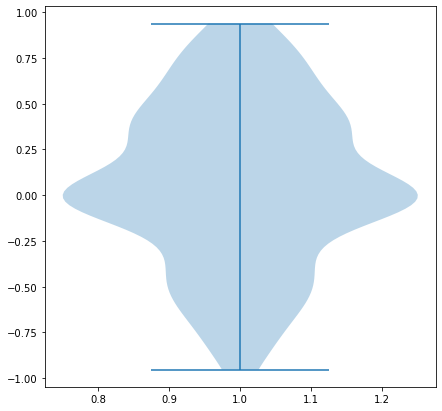

In [121]:
# Creating dataset
data = tweets_df2['sentiment_score']

fig = plt.figure(figsize =(7, 7))

# Creating plot
plt.violinplot(data, vert=True)

# show plot
plt.show()


In [ ]:
Axes.violinplot(dataset, positions=None, vert=True, widths=0.5, showmeans=False, showextrema=True, showmedians=False, quantiles=None, points=100, bw_method=None, *, data=None)


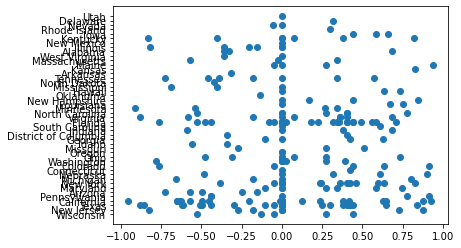

In [82]:
import statsmodels.api as sm
import pandas as pd

# defining the variables
x = df['sentiment_score'].tolist()
y = df['state'].tolist()
plt.scatter(x, y)

max_x = df['sentiment_score'].max()
min_x = df['sentiment_score'].min()

x = np.arange(min_x, max_x, 1)

# adding the constant term
#x = sm.add_constant(x)
 
# performing the regression
# and fitting the model
#result = sm.OLS(y, x).fit()

# printing the summary table
#print(result.summary())

In [30]:
tweets_df2_test = tweets_df2.loc[tweets_df2['state'] == 'Florida']

In [120]:


df_new = tweets_df2.groupby('state') \
       .agg(count=('state', 'size'), mean_sentiment=('sentiment_score', 'mean')) \
       .reset_index()

#df_new2 = df_new.loc[df_new['count'] > 4]

df_new3 = df_new.sort_values('state', ascending=True, inplace=False, kind='quicksort', na_position='last')
df_new3

state  count  mean_sentiment
0                Alabama      3       -0.001867
1                Arizona      5       -0.439240
2               Arkansas      1       -0.318200
3             California     27       -0.037307
4               Colorado      5        0.235180
5            Connecticut      2        0.210750
6               Delaware      1        0.318200
7   District of Columbia      2        0.030950
8                Florida     25        0.125764
9                Georgia      4        0.235925
10                Hawaii      3        0.457333
11                 Idaho      2       -0.448700
12              Illinois      6       -0.255700
13               Indiana      4        0.117950
14                  Iowa      3        0.562000
15                Kansas      1        0.827100
16              Kentucky      7        0.006014
17             Louisiana      3        0.474667
18                 Maine      4        0.289675
19              Maryland      7        0.262771
20         Massachusetts      3       -0.084867
21              Michigan      4       -0.008900
22             Minnesota      4       -0.211925
23           Mississippi      3       -0.364000
24              Missouri      3        0.170600
25              Nebraska      5        0.270860
26                Nevada      2       -0.028600
27         New Hampshire      4        0.363625
28            New Jersey      8        0.041000
29            New Mexico      1        0.000000
30              New York     16        0.234369
31        North Carolina      7        0.189800
32          North Dakota      1       -0.421500
33                  Ohio      7        0.043057
34              Oklahoma      1       -0.135100
35                Oregon      2        0.000000
36          Pennsylvania      5        0.162220
37          Rhode Island      1        0.296000
38        South Carolina      2        0.306200
39             Tennessee      7       -0.120129
40                 Texas     29       -0.026521
41                  Utah      1        0.000000
42              Virginia      9        0.026544
43            Washington      8       -0.011350
44         West Virginia      2       -0.180600
45             Wisconsin      5        0.001780

## Machine learning

### test train split

In [100]:
tweets_df3 = tweets_df2.copy()

In [101]:
# list of tweet sentiments
tweet_sentiments = [0 if i<0 else 1 for i in tweets_df3.sentiment_score]

In [102]:

# splitting dataset into test and train
df_train, df_test = train_test_split(tweets_df3, test_size=.5, random_state=1337)


In [103]:
# Sort the data randomly to mix positive and negative reviews
np.random.seed(0)
df_train = tweets_df2.reindex(np.random.permutation(df_train.index))
df_test = tweets_df2.reindex(np.random.permutation(df_test.index))

# Take out X and Y variable
x_train = df_train['text'].values
x_test = df_test['text'].values
y_train = df_train['tweet_sentiment'].values
y_test = df_test['tweet_sentiment'].values

# Make our bag of words
tfidf = TfidfVectorizer()
x_train_bag = tfidf.fit_transform(x_train)

# Fit the model
lr_text = LogisticRegression(random_state=0) #Text classifier
lr_text.fit(x_train_bag,y_train)

LogisticRegression(random_state=0)

In [104]:
tweets_bag = tfidf.transform(tweets_df3['text'].values)

preds = lr_text.predict(tweets_bag)
print("Testing accuracy =",np.mean([(preds==tweets_df2['tweet_sentiment'])]))

Testing accuracy = 0.6820083682008368


### ML v2

In [90]:
tweets_df3.head()

created_at  \
0 2021-01-04 23:59:24+00:00   
1 2021-01-04 23:59:06+00:00   
2 2021-01-04 23:58:24+00:00   
3 2021-01-04 23:57:27+00:00   
4 2021-01-04 23:57:21+00:00   

                                                text               source  \
0  theres no reason  none whatsoever  to waste an...   Twitter for iPhone   
1  union co will begin to offer phase a covid vac...   Twitter for iPhone   
2      my family is ready and willing but were un...   Twitter for iPhone   
3  if a new wave of infections as a result of a n...   Twitter for iPhone   
4   yes the republicans save the america they clo...  Twitter for Android   

                                name         username    user_location  \
0                         Amy Curtis   RantyAmyCurtis    Milwaukee, WI   
1  Committeeman Christopher Capodice    ChrisCapodice  Springfield, NJ   
2                     Shannon Marino      smarino1002      Houston, TX   
3                        Adam Merino       adammerino   New York City    
4                  Sharon Perreault   SharonPerreaul1             None   

      tweet_location country_code  verified  \
0      Milwaukee, WI           US     False   
1    Springfield, NJ           US     False   
2        Tomball, TX           US     False   
3  San Francisco, CA           US     False   
4          Leola, PA           US     False   

                                         description           city  \
0  RN, Mom, traditional Catholic, combative nerd....      Milwaukee   
1  Former Mayor, currently serves as Township Com...            NaN   
2  Higher Ed/Student Affairs. Have courage and be...            NaN   
3  @forbes Top Next-Gen Wealth Advisor @SpecOlymp...  San Francisco   
4  I am a happily married woman who has 4 childre...            NaN   

          state        country  sentiment_score  tweet_sentiment  
0     Wisconsin  United States          -0.0232                0  
1    New Jersey  United States           0.7269                1  
2         Texas  United States          -0.5483                0  
3    California  United States           0.3818                1  
4  Pennsylvania  United States           0.7783                1

In [105]:
# Make our bag of words
tfidf_tweet = TfidfVectorizer()
tweets_new_bag = tfidf_tweet.fit_transform(tweets_df3['text'].values)

# Fit the model
lr_tweets = LogisticRegression(random_state=0) #Text classifier
lr_tweets.fit(tweets_new_bag, tweet_sentiments)


LogisticRegression(random_state=0)

In [107]:

# Make our bag of words
tweets_features = ['_'.join(s.split()) for s in tfidf_tweet.get_feature_names_out()]
tweets_coefficients = lr_tweets.coef_
tweets_coefs_df = pd.DataFrame.from_records(tweets_coefficients, columns=tweets_features)

# Most important (positive and negative) features:
print()
print(tweets_coefs_df.T.sort_values(by=[0], ascending=False).head(50))
print()
print(tweets_coefs_df.T.sort_values(by=[0], ascending=True).head(50))



                     0
got           0.875174
need          0.572002
vaccine       0.511141
today         0.476357
covid         0.472806
make          0.453994
return        0.417495
update        0.404519
one           0.368894
next          0.366469
first         0.361679
rona          0.355477
done          0.334313
received      0.328062
great         0.321149
right         0.311540
get           0.310537
system        0.307344
good          0.299067
peoples       0.297170
shot          0.291972
signed        0.289751
distributed   0.284186
mom           0.283787
metal         0.282932
thanks        0.275665
end           0.272070
available     0.269083
grateful      0.266864
away          0.266731
announced     0.262456
johnson       0.260328
appointments  0.254507
definitely    0.254136
man           0.250894
biden         0.250274
january       0.248600
working       0.247228
enough        0.244003
vaccines      0.242781
sitting       0.236780
please        0.235088
youve     

### Tokenization

In [93]:
text_tokens = nltk.tokenize.word_tokenize(text)
text_tokens

['received',
 'first',
 'two',
 'covid',
 'vaccine',
 'today',
 'first',
 'responder',
 'thanks',
 'personnel',
 'great',
 'job',
 'us']

### Stemming

In [66]:
porter = nltk.PorterStemmer()
review_stemmed = [porter.stem(i) for i in review_nostop]
review_stemmed

received first two covid vaccine today first responder. thanks personnel great job us! = received first two covid vaccine today first responder. thanks personnel great job us!


## 7. Scraping of 2020 US presidential election results from Wiki

In [153]:
#Start by importing the website where we want to extract the data from
dfs = pd.read_html('https://en.wikipedia.org/wiki/2020_United_States_presidential_election')

#seeing that the table we want is the nr19 therefore we extract that
table_stat = dfs[19]

#from the above we see that there are 2 type of headers. We want to deal with this, therefore we put the two columns together 
#by f-string formatting 
table_stat.columns = [f'{i}{j}' for i, j in table_stat.columns]
table_stat.head()

State ordistrictState ordistrict Biden/HarrisDemocraticVotes  \
0                            Alab.                      849624   
1                           Alaska                      153778   
2                          Arizona                     1672143   
3                             Ark.                      423932   
4                           Calif.                    11110250   

  Biden/HarrisDemocratic% Biden/HarrisDemocraticEV Trump/PenceRepublicanVotes  \
0                  36.57%                        –                    1441170   
1                  42.77%                        –                     189951   
2                  49.36%                       11                    1661686   
3                  34.78%                        –                     760647   
4                  63.48%                       55                    6006429   

  Trump/PenceRepublican% Trump/PenceRepublicanEV  \
0                 62.03%                       9   
1                 52.83%                       3   
2                 49.06%                       –   
3                 62.40%                       6   
4                 34.32%                       –   

  Jorgensen/CohenLibertarianVotes Jorgensen/CohenLibertarian%  \
0                           25176                       1.08%   
1                            8897                       2.47%   
2                           51465                       1.52%   
3                           13133                       1.08%   
4                          187895                       1.07%   

  Jorgensen/CohenLibertarianEV Hawkins/WalkerGreenVotes Hawkins/WalkerGreen%  \
0                            –                      [m]                  [m]   
1                            –                      [n]                  [n]   
2                            –                     1557                0.05%   
3                            –                     2980                0.24%   
4                            –                    81029                0.46%   

  Hawkins/WalkerGreenEV OthersVotes Others% OthersEV MarginVotes  Margin%  \
0                     –        7312   0.31%        –    −591,546  −25.46%   
1                     –        6904   1.92%        –     −36,173  −10.06%   
2                     –         475   0.01%        –       10457    0.31%   
3                     –       18377   1.51%        –    −336,715  −27.62%   
4                     –      115278   0.66%        –     5103821   29.16%   

  Marginswing[l]% TotalvotesTotalvotes  
0           2.27%              2323282  
1           4.67%               359530  
2           3.81%              3387326  
3          −0.70%              1219069  
4          −0.95%             17500881

In [167]:
#then we drop the columns we are not interested in, since we only want to compare Democrats and Republicans
table_stat1= table_stat.drop(table_stat.columns[[3, 6]], axis=1)
table_stat2 = table_stat1.drop(table_stat1.iloc[:, 5:18], axis=1)

#removing extra rows from Maine and Newbraske due to the election rules in these state
table_stat3= table_stat2.drop(table_stat.index[[20, 21,30, 31, 32, 56, 57]], axis=0)

# Manually handling the states so their are inlibne with the twitter data. Thereby we can merge the data
table_stat4 = table_stat3.replace(['Alab.','Ark.','Calif.', 'Colo.', 'Conn.', 'Del.', 'D.C.' , 'Ky.', 'La.', 'Maine †', 'Md.', 'Mass.', 'Mich.',
                                  'Minn.', 'Miss.', 'Mo.' , 'Mont.', 'Neb. †', 'Nev.[p]', 'N.H.', 'N.J.[q]' , 'N.M.', 'N.Y.[r]', 'N.C.',
                                  'N.D.', 'Okla.', 'Pa.' , 'R.I.', 'S.C.', 'S.D.', 'Tenn.','Texas[t]', 'Vt.' , 'Va.', 'Wash.', 'W.Va.',
                                  'Wis.', 'Wyo.'], 
                                  ['Alabama','Arkansas','California','Colorado', 'Connecticut', 'Delaware', 'District of Columbia', 'Kentucky',
                                  'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montanna',
                                  'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota',
                                  'Oklahoma', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Vermont',
                                  'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'])

#renaming columns to give them more intuitive names for comparison 
table_stat5 = table_stat4.rename(columns = {'State ordistrictState ordistrict':'state', 
                              'Biden/HarrisDemocraticVotes':'Democratic', 'Biden/HarrisDemocratic%':'Democraticpct', 
                              'Trump/PenceRepublicanVotes':'Republican', 'Trump/PenceRepublican%' : 'Republicanpct'})

table_stat5.head(4)



state Democratic Democraticpct Republican Republicanpct
0   Alabama     849624        36.57%    1441170        62.03%
1    Alaska     153778        42.77%     189951        52.83%
2   Arizona    1672143        49.36%    1661686        49.06%
3  Arkansas     423932        34.78%     760647        62.40%

In [170]:
#Comparing the vote pct to see if the state is either Democratic (blue) or Republican (red) and adding a new collum
comparison_column = np.where(table_stat5["Democraticpct"] > table_stat5["Republicanpct"], 'Blue', 'Red')
#comparison_pct_column = np.where(table_stat5["Democraticpct"] > table_stat5["Republicanpct"], table_stat5["Democratic"]-table_stat5["Republican"], 1)


table_stat5["Red/Blue State"] = comparison_column
#table_stat5["pct_dif"] = comparison_pct_column

table_stat5.head(5)

state Democratic Democraticpct Republican Republicanpct Red/Blue State
0     Alabama     849624        36.57%    1441170        62.03%            Red
1      Alaska     153778        42.77%     189951        52.83%            Red
2     Arizona    1672143        49.36%    1661686        49.06%           Blue
3    Arkansas     423932        34.78%     760647        62.40%            Red
4  California   11110250        63.48%    6006429        34.32%           Blue

In [181]:
tweets_df2_test = tweets_df2.loc[tweets_df2['state'] == 'California']
tweets_df2_test.merge(table_stat5, how='inner', on='state')

created_at  \
0  2021-01-04 23:57:27+00:00   
1  2021-01-04 23:55:01+00:00   
2  2021-01-04 23:52:22+00:00   
3  2021-01-04 23:43:43+00:00   
4  2021-01-04 23:42:49+00:00   
5  2021-01-04 23:32:35+00:00   
6  2021-01-04 23:15:09+00:00   
7  2021-01-04 23:15:03+00:00   
8  2021-01-04 23:08:01+00:00   
9  2021-01-04 23:03:16+00:00   
10 2021-01-04 22:53:59+00:00   
11 2021-01-04 22:46:14+00:00   
12 2021-01-04 22:30:17+00:00   
13 2021-01-04 22:20:12+00:00   
14 2021-01-04 22:15:25+00:00   
15 2021-01-04 22:07:52+00:00   
16 2021-01-04 22:06:39+00:00   
17 2021-01-04 22:02:40+00:00   
18 2021-01-04 21:59:52+00:00   
19 2021-01-04 21:47:57+00:00   
20 2021-01-04 21:46:48+00:00   
21 2021-01-04 21:44:36+00:00   
22 2021-01-04 21:42:42+00:00   
23 2021-01-04 21:41:04+00:00   
24 2021-01-04 21:39:41+00:00   
25 2021-01-04 21:26:10+00:00   
26 2021-01-04 21:21:49+00:00   

                                                 text               source  \
0   new wave infections result new variant strain ...   Twitter for iPhone   
1   shame approving vaccine cant even protect pers...  Twitter for Android   
2   vaccine amp company helped manufacture amp com...  Twitter for Android   
3   fucking sick incompetence every goddamn level ...  Twitter for Android   
4   oh gosh looks like child arguing parent cnn se...  Twitter for Android   
5                   regular updates process find info   Twitter for iPhone   
6   dr fauci says slow covid vaccine rollout disap...  Twitter for Android   
7                    wouldnt take vaccine ohio either   Twitter for iPhone   
8   fair point fault person whos vaccinated cant e...   Twitter for iPhone   
9                          wont go away covid vaccine     Twitter for iPad   
10  shame getting vaccine matter shaming systems s...   Twitter for iPhone   
11  maryland maryland covid vaccine slow especiall...   Twitter for iPhone   
12  never said invented covid said new type vaccin...   Twitter for iPhone   
13  today residency interviews second dose covid v...   Twitter for iPhone   
14  sc wants ban mandated covid vaccine unless the...  Twitter for Android   
15                             got covid vaccine shot  Twitter for Android   
16  bro choose take vaccine thats cool dont annoyi...   Twitter for iPhone   
17  vaccine ill go games start get vaccine cant go...   Twitter for iPhone   
18  virus stay news media never blame biden also v...   Twitter for iPhone   
19  idc youre vaccine people posting got covid vac...   Twitter for iPhone   
20  theres million vaccines sitting shelf right no...   Twitter for iPhone   
21          shot maderna vaccine nycvaxchamp elmhurst            Instagram   
22  undocumented immigrants good enough make profi...   Twitter for iPhone   
23  weeeiiillll kinda still worry rally crash vacc...  Twitter for Android   
24  breaking police officers first cops louisiana ...   Twitter for iPhone   
25  public needs vaccinated asap youre dicking aro...   Twitter for iPhone   
26  im still learning towards binary event reason ...  Twitter for Android   

                                              name         username  \
0                                      Adam Merino       adammerino   
1                                    Marina Martin  StanfordGeriDoc   
2                         Michael Francis Williams       parleyment   
3                                 Lauri Parizo. ✍️    LauriParizo72   
4             🌻LittleDesertFlower📚الداغستاني🌼νοέω🔥  LittleDsrtFlowr   
5                                  Go Grande Rojo🌽      WeDemBoyz89   
6                                           J Kolb         JKolbIII   
7                                   Elizabeth Cook    ElizabethKPIX   
8                                   Joel Selanikio       jselanikio   
9                                    Raunedys Peña          NadiesP   
10  Kimberly Y. Moore, CEO & Cofounder @GoTogether         kymoore1   
11                                  larry l. burks     larryburks47   
12           

In [179]:
tweets_df2

created_at  \
0   2021-01-04 23:59:24+00:00   
1   2021-01-04 23:59:06+00:00   
2   2021-01-04 23:58:24+00:00   
3   2021-01-04 23:57:27+00:00   
4   2021-01-04 23:57:21+00:00   
..                        ...   
258 2021-01-04 21:08:34+00:00   
259 2021-01-04 21:08:30+00:00   
260 2021-01-04 21:07:53+00:00   
261 2021-01-04 21:07:28+00:00   
262 2021-01-04 21:07:02+00:00   

                                                  text               source  \
0    theres reason none whatsoever waste dose covid...   Twitter for iPhone   
1    union co begin offer phase covid vaccinations ...   Twitter for iPhone   
2    family ready willing unable find vaccine area ...   Twitter for iPhone   
3    new wave infections result new variant strain ...   Twitter for iPhone   
4    yes republicans save america closed borders ea...  Twitter for Android   
..                                                 ...                  ...   
258  give covid update wednesday pm focus vaccine roll   Twitter for iPhone   
259          got first dose covid vaccine feelpowerful   Twitter for iPhone   
260  yikes article title says new covid variant mig...   Twitter for iPhone   
261          covid vaccine work new coronavirus strain   Twitter for iPhone   
262  funny lot people dont believe virus first line...   Twitter for iPhone   

                                  name         username     user_location  \
0                           Amy Curtis   RantyAmyCurtis     Milwaukee, WI   
1    Committeeman Christopher Capodice    ChrisCapodice   Springfield, NJ   
2                       Shannon Marino      smarino1002       Houston, TX   
3                          Adam Merino       adammerino    New York City    
4                    Sharon Perreault   SharonPerreaul1              None   
..                                 ...              ...               ...   
258                 lydia, on wheels!🛼       lydiaheals               RVA   
259                      K'lyssa Moore           klyssa       Lubbock, TX   
260                               ｓｈａｅ       _shaeebaee  •ѕρяιиgfιєℓ∂,Ҝy•   
261                       John Flowers    MrJohnFlowers       Milford, CT   
262                       Sean Mitchem       jayhawkscm   Kansas City, Mo   

         tweet_location country_code  verified  \
0         Milwaukee, WI           US     False   
1       Springfield, NJ           US     False   
2           Tomball, TX           US     False   
3     San Francisco, CA           US     False   
4             Leola, PA           US     False   
..                  ...          ...       ...   
258  Salt Lake City, UT           US     False   
259         Huntley, IL           US     False   
260        Farragut, TN           US     False   
261       Green Bay, WI           US      True   
262      Des Moines, WA           US     False   

                                           description            city  \
0    RN, Mom, traditional Catholic, combative nerd....       Milwaukee   
1    Former Mayor, currently serves as Township Com...             NaN   
2    Higher Ed/Student Affairs. Have courage and be...             NaN   
3    @forbes Top Next-Gen Wealth Advisor @SpecOlymp...   San Francisco   
4    I am a happily married woman who has 4 childre...             NaN   
..                                                 ...             ...   
258         She/her - A solid 4️⃣ Wizard of loneliness  Salt Lake City   
259  K'lyssa Elise. Mom. Wife. Teacher. BSB lover. ...             NaN   
260            |WKU Alumna👩🏽‍🎓| 1908💚💕| VIII.XXI.MMXX💔             NaN   
261  Writer @CNN for @AC360. ex-@CNBC @MSNBC @TIME....       Green Bay   
262  I have been a Kansas City Chiefs season ticket...      Des Moines   

            state        country  sentiment_score  tweet_sentiment  
0       Wisconsin  United States           0.2755                1  
1      New Jersey  United States           0.7269                1  
2           Texas  United States          -0.1027  